## Apiux & SII: Propagacion de contaminacion de contribuyentes en la malla comercial.

## Henry Vega (henrry.vega@api-ux.com)
## Data scientist

Para poder realizar una propagacion de riesgo, consideraremos que éste se puede propagar debido a una influencia directa de un contribuyente sobre otro. Por ejemplo, al considerar una relación patrimonial o familiar, o debido a un impacto indirecto, como al considerar una relación comercial donde por ejemplo si una de las partes en la relación no cumple de forma correcta todas sus obligaciones tributarias podría afectar a que la otra parte no cumpla o cumpla parcialmente con las suyas, luego en este caso no hay un influencia directa en el comportamiento del contribuyente contaminado, sino que la contaminación se da de forma indirecta. En el caso de este algoritmo propuesto, se consideran las relaciones comerciales, considerando el IVA de las transacciones de una entidad con otra. Junto con las fuerzas de relaciones, hay un valor de contaminacion que inicialmente es 0 o 1 para cada entidad (considerando que ya estaba contaminado en base a alguna alerta o no lo esta). La propagacion se ejecuta con estas condiciones iniciales.

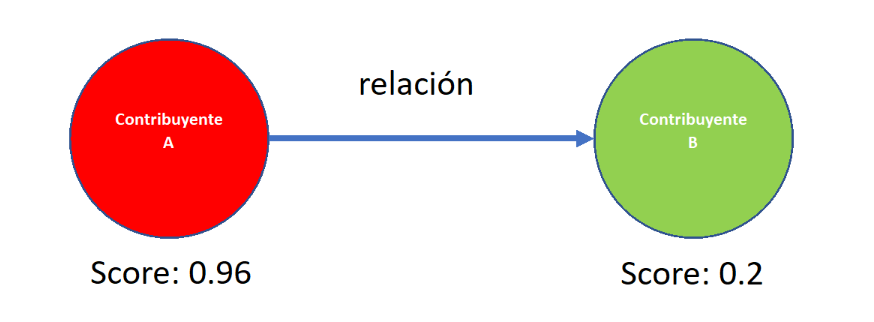

La fuerza entre entidades tiene la condicion de creacion de estar en el rango [0,1].

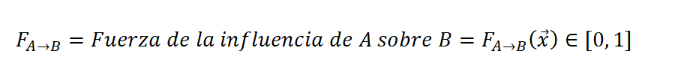

Eventualmente, muchas entidades A se pueden relacionar comercialmente con B, segn el siguiente diagrama. De esta forma se tendira que actualizar el valor de scoring de B de acuerdo a los valores de scoring de A y las fuerzas correspondientes.
Como ejemplo, consideremos tres entidades A que se han relacionado comercialmente con una entidad B. 

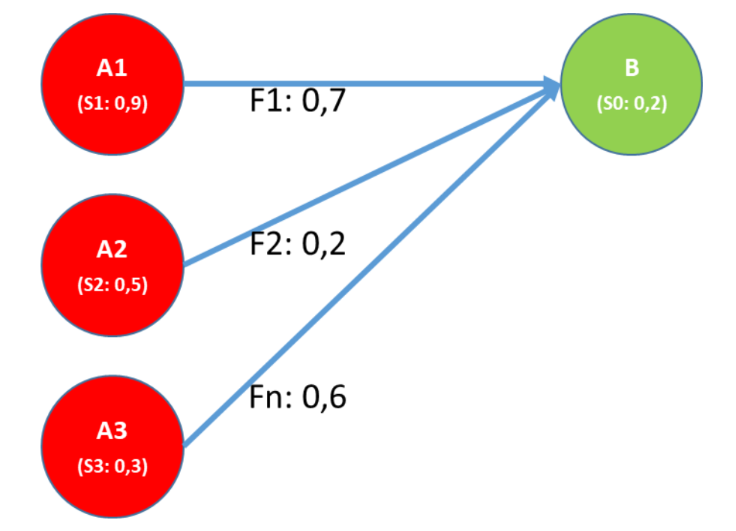

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt


In [2]:
spark = SparkSession.builder \
  .appName("Test")  \
  .config("spark.yarn.access.hadoopFileSystems","abfs://data@datalakesii.dfs.core.windows.net/") \
  .config("spark.executor.memory", "24g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.executor.cores", "12") \
  .config("spark.executor.instances", "24") \
  .config("spark.driver.maxResultSize", "12g") \
  .getOrCreate()

warnings.filterwarnings('ignore', category=DeprecationWarning)
sc=spark.sparkContext
sc.setLogLevel ('ERROR')

Setting spark.hadoop.yarn.resourcemanager.principal to yasser.nanjari


El algoritmo se basa en establecer la fuerza de las relaciones comerciales entre entidades y luego realizar una actualizacion de los valores de contaminacion para cada uno de ellos.La propagacion de contaminacion se hara hacia adelante, es decir lo receptores de factura son contaminados por las entidades emisoras. 

Leemos la data de fuerza a partir de los datos procesados, de una fuerza para cada arco entre contribuyente A y B.

Tomamos la fuerza que corresponde al promedio de las fuerzas (en caso de existir ambas) o el valor existente entre arcos. 

In [3]:
spark.read.options(header=True,inferSchema=True,delimiter=",").csv("../../data/processed/fuerza_representante.csv").createOrReplaceTempView("fuerza1")
spark.read.options(header=True,inferSchema=True,delimiter=",").csv("../../data/processed/fuerza_iva.csv").createOrReplaceTempView("fuerza2")

In [4]:
spark.sql("SELECT fuerza1.emisor as emisor1, fuerza1.receptor as receptor1, fuerza2.emisor as emisor2, fuerza2.receptor as receptor2, fuerza1.Fi as Fi1, fuerza2.Fi as Fi2 from fuerza1 full join fuerza2 on (fuerza1.emisor=fuerza2.emisor and fuerza1.receptor=fuerza2.receptor)").createOrReplaceTempView("fuerza") 

In [5]:
spark.sql("SELECT case when emisor1 is null then emisor2 else emisor1 end as emisor, case when receptor1 is null then receptor2 else receptor1 end as receptor, case when Fi1 is null then Fi2 else Fi1 end as FiA, case when Fi2 is null then Fi1 else Fi2 end as FiB  from fuerza").createOrReplaceTempView("fuerza")
spark.sql("SELECT emisor, receptor, (FiA/2+FiB/2) as Fi from fuerza").createOrReplaceTempView("fuerza")
spark.sql("SELECT * from fuerza").show()

+--------------------+--------------------+------+
|              emisor|            receptor|    Fi|
+--------------------+--------------------+------+
|+++4/3jzUwtDPSSo3...|RoW0pFG+GHdTz7TIL...|0.0099|
|++/fV7MkjN3EYCFO8...|+pVjkHfMSeYf4Y75y...|0.0027|
|++/fV7MkjN3EYCFO8...|KYXxQJX2SVGHr0Ws9...|0.0416|
|++/fV7MkjN3EYCFO8...|dJZ3p+eKLtAlpKJkB...|9.0E-4|
|++0TZZ4dLrh7Mcrrq...|iEn2yUp2JAd2MXS1l...|2.0E-4|
|++1JNpbthfwgogYLW...|+cJKFXmYppdWLge7h...|6.0E-4|
|++1JNpbthfwgogYLW...|0PDWkh5MIHiJc3Zrb...|   1.0|
|++1JNpbthfwgogYLW...|2BTQtLMiizf606rJv...|0.0013|
|++1JNpbthfwgogYLW...|3on2HNr9ZWE+cTP24...|2.0E-4|
|++1JNpbthfwgogYLW...|5MhPBjYcW6keF8g0V...|0.5791|
|++1JNpbthfwgogYLW...|7x2IgoYG1HzSGOWgM...|2.0E-4|
|++1JNpbthfwgogYLW...|9Zc8Yu2M37U0fjr3f...|2.0E-4|
|++1JNpbthfwgogYLW...|BUQ5T7GRsIgQxyrzx...|   0.0|
|++1JNpbthfwgogYLW...|D1mRa3Gs7UqgNdyEN...|   1.0|
|++1JNpbthfwgogYLW...|DkMNRmExUfuF4cNL2...|   0.0|
|++1JNpbthfwgogYLW...|E+I8Qb5laeMx8Vl++...|0.0019|
|++1JNpbthfwgogYLW...|EvnQDeNBq

In [6]:
#En las siguientes lineas podemos ver la transformacion de la data basada en las operaciones matematicas descritas en la portada del proyecto
spark.sql("SELECT receptor ,(EXP(SUM(LN(NULLIF(ABS(1-Fi),0))))) AS f0 ,sum(Fi) as sFi from  fuerza group by receptor order by receptor asc ").createOrReplaceTempView("fuerza_aux")
# spark.sql("SELECT *  from fuerza_aux").show() 
spark.sql("SELECT emisor,  fuerza.receptor,Fi,f0,sFi from fuerza left join fuerza_aux on fuerza.receptor=fuerza_aux.receptor").createOrReplaceTempView("fuerza")
# spark.sql("SELECT *  from fuerza").show() 
spark.sql("SELECT emisor,receptor, Fi, case when f0 is NULL then 0 else f0 end as f0,sFi from fuerza order by receptor asc").createOrReplaceTempView("fuerza")
# spark.sql("SELECT *  from fuerza").show() 
spark.sql("SELECT emisor,receptor, Fi,f0, round((1-f0)*Fi,4) as f,sFi from fuerza order by receptor asc").createOrReplaceTempView("fuerza")
# spark.sql("SELECT *  from fuerza").show() 
# Ahora se agrega una correcion para dividir fi por el tutal de la suma de Fi. En el caso que la fuerza sea cero, no se realiza la division, pero para los otros casos si )de esta forma nos cercioramos de que sea distinto de cero.
spark.sql("SELECT emisor, receptor, Fi, f0, case when f=0 then f else f/sFi end as f from fuerza order by sFi desc").createOrReplaceTempView("fuerza") 
spark.sql("SELECT * from fuerza order by f desc").show() 


+--------------------+--------------------+---+---+---+
|              emisor|            receptor| Fi| f0|  f|
+--------------------+--------------------+---+---+---+
|FLIGgKkAbFkg/49l0...|++NHnATs/qs4evB9A...|1.0|0.0|1.0|
|LWC+VfvAOHG7mdWhY...|++0oswlRcJ8rKYhrx...|1.0|0.0|1.0|
|ZeO/XqRbjkkIZD/gW...|+++PplbWmUr0+EBsI...|1.0|0.0|1.0|
|jmwZ09/b7g6xHZfE9...|++6JZXLgECmlNtzbm...|1.0|0.0|1.0|
|8Bs4i9uDcenCDGbtf...|++OT3d3W1ro2yqZfT...|1.0|0.0|1.0|
|8cFyR319RFkoK3Srp...|++TYGij3MEL4eOKyh...|1.0|0.0|1.0|
|Q/JIZxHyPwGbYjoX2...|++U8G6oiQF9K61Bqe...|1.0|0.0|1.0|
|+0yKx5GSw/Q5FoSrp...|++eXnuQHae0KUChw+...|1.0|0.0|1.0|
|KW54WQMaOpk53HeZi...|++hmrBaDTAYF60xMY...|1.0|0.0|1.0|
|PXUM2eYGE4Tniwsr4...|++hxQANzSxKZb1PeA...|1.0|0.0|1.0|
|v1TbXH4GYKJgpur4d...|++jyyZcTKXU5VtvOL...|1.0|0.0|1.0|
|W07B554d/cgF09XHZ...|+/Mss69tNTaMpi8A4...|1.0|0.0|1.0|
|+0yKx5GSw/Q5FoSrp...|+/OC+Zczq2T8Unq6z...|1.0|0.0|1.0|
|SR1uHiJfuh92SmpAE...|+/OE5X9SW5XDNC7OG...|1.0|0.0|1.0|
|v1TbXH4GYKJgpur4d...|+/SY/Ux8PJPfwtchI...|1.0|0

In [7]:
spark.sql("SELECT emisor as rut from fuerza").createOrReplaceTempView("a")
spark.sql("SELECT receptor as rut from fuerza").createOrReplaceTempView("b")
spark.sql("SELECT rut FROM a UNION ALL SELECT rut FROM b ORDER BY rut asc").createOrReplaceTempView("c")
spark.sql("SELECT distinct(rut) from c").createOrReplaceTempView("c")
spark.sql("SELECT rut, 0 as score_i from c").createOrReplaceTempView("c")
spark.sql("SELECT count(*) from c").show()


+--------+
|count(1)|
+--------+
| 4339827|
+--------+



In [8]:
df = spark.read.options(header=True,inferSchema=True,delimiter=",").csv("../../data/processed/contaminados.csv")
df.createOrReplaceTempView("contaminados")

In [9]:
spark.sql("SELECT * from c left join contaminados on c.rut=contaminados.cont_rut").createOrReplaceTempView("contaminados")

In [10]:
contaminados=spark.sql("SELECT rut as cont_rut, case when score is not null and score>score_i then score else score_i end as score from contaminados")

In [11]:
contaminados_total=contaminados.toPandas()
contaminados_total.to_csv('../../data/processed/contaminados_processed_iva_representante.csv', index=False)

5704
44611
              score
count  4.339827e+06
mean   7.361492e-03
std    7.868806e-02
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.000105e+00


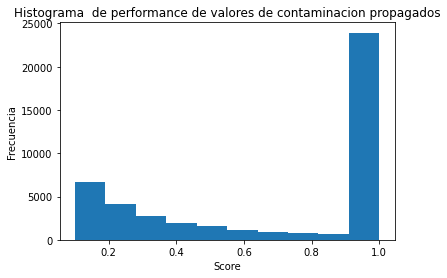

9788
62657
              score
count  4.339827e+06
mean   1.077778e-02
std    8.300656e-02
min    0.000000e+00
25%    0.000000e+00
50%    2.886997e-04
75%    1.509662e-03
max    1.000115e+00


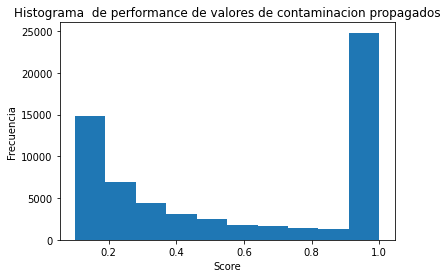

12199
78012
              score
count  4.339827e+06
mean   1.498222e-02
std    8.544194e-02
min    0.000000e+00
25%    1.110002e-03
50%    2.610626e-03
75%    6.189252e-03
max    1.000122e+00


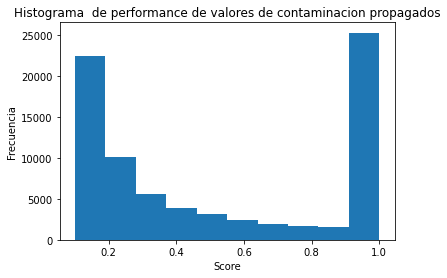

13305
91250
              score
count  4.339827e+06
mean   1.958540e-02
std    8.672167e-02
min    0.000000e+00
25%    3.516348e-03
50%    6.237550e-03
75%    1.174296e-02
max    1.000125e+00


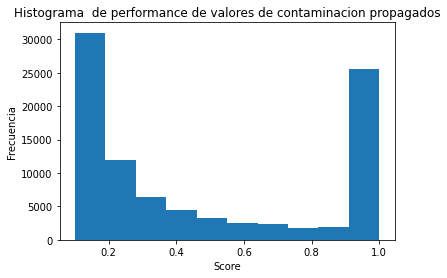

13925
102651
              score
count  4.339827e+06
mean   2.452092e-02
std    8.729495e-02
min    0.000000e+00
25%    6.976032e-03
50%    1.071691e-02
75%    1.763462e-02
max    1.000125e+00


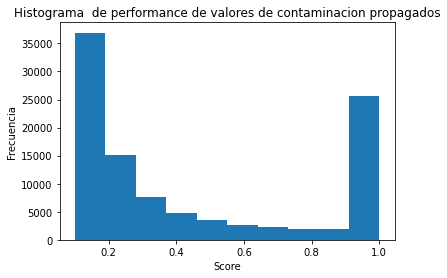

14370
112543
              score
count  4.339827e+06
mean   2.964507e-02
std    8.745766e-02
min    0.000000e+00
25%    1.115482e-02
50%    1.571783e-02
75%    2.351725e-02
max    1.000125e+00


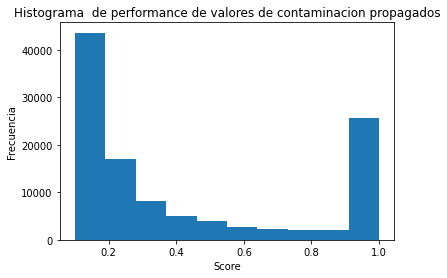

14807
122813
              score
count  4.339827e+06
mean   3.484156e-02
std    8.738302e-02
min    0.000000e+00
25%    1.579934e-02
50%    2.084196e-02
75%    2.903642e-02
max    1.000126e+00


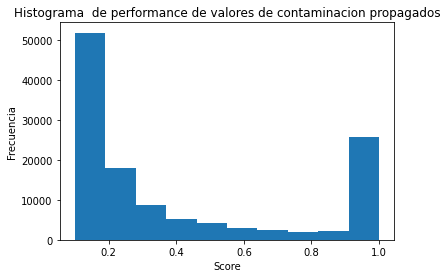

15012
133516
              score
count  4.339827e+06
mean   4.004111e-02
std    8.716728e-02
min    0.000000e+00
25%    2.057507e-02
50%    2.613709e-02
75%    3.490073e-02
max    1.000126e+00


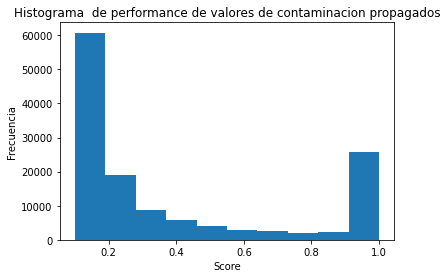

15171
151200
              score
count  4.339827e+06
mean   4.521170e-02
std    8.686652e-02
min    0.000000e+00
25%    2.556344e-02
50%    3.132915e-02
75%    4.043468e-02
max    1.000126e+00


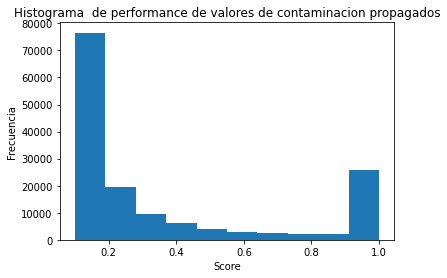

15352
162146
              score
count  4.339827e+06
mean   5.034247e-02
std    8.651391e-02
min    0.000000e+00
25%    3.064354e-02
50%    3.657579e-02
75%    4.580195e-02
max    1.000126e+00


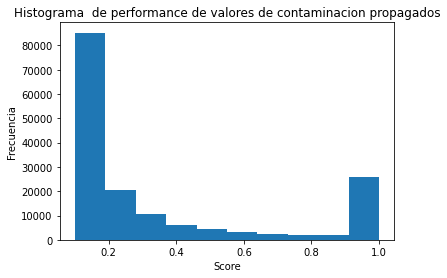

15628
172790
              score
count  4.339827e+06
mean   5.543266e-02
std    8.612978e-02
min    0.000000e+00
25%    3.583495e-02
50%    4.179545e-02
75%    5.110899e-02
max    1.000126e+00


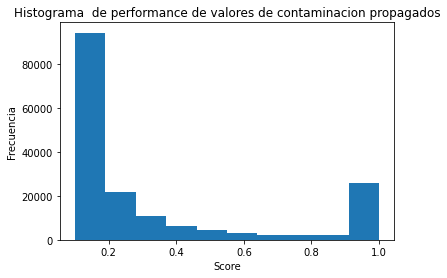

15746
205305
              score
count  4.339827e+06
mean   6.048545e-02
std    8.572649e-02
min    0.000000e+00
25%    4.096377e-02
50%    4.700681e-02
75%    5.615070e-02
max    1.000126e+00


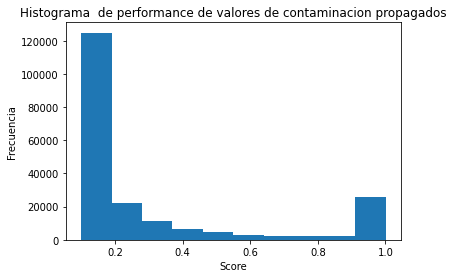

15872
224052
              score
count  4.339827e+06
mean   6.550506e-02
std    8.531174e-02
min    0.000000e+00
25%    4.605162e-02
50%    5.212099e-02
75%    6.125473e-02
max    1.000126e+00


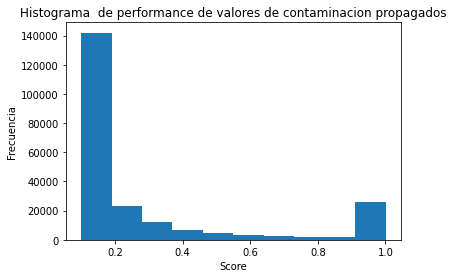

15981
253490
              score
count  4.339827e+06
mean   7.049555e-02
std    8.489032e-02
min    0.000000e+00
25%    5.112638e-02
50%    5.723415e-02
75%    6.633007e-02
max    1.000126e+00


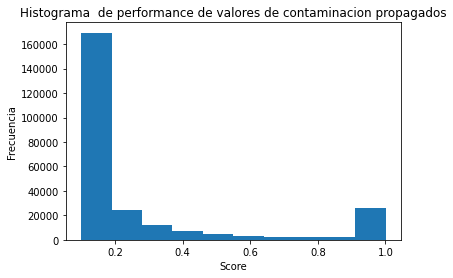

16102
285721
              score
count  4.339827e+06
mean   7.546030e-02
std    8.446528e-02
min    0.000000e+00
25%    5.621271e-02
50%    6.234690e-02
75%    7.133203e-02
max    1.000126e+00


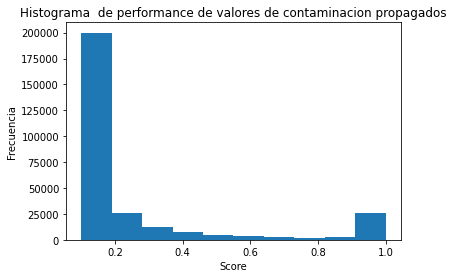

<Axes: xlabel='iterations'>

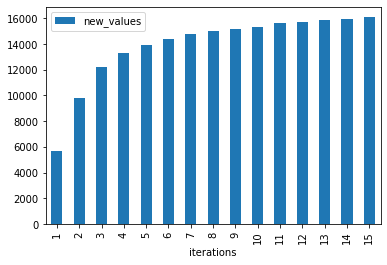

In [12]:
performance = pd.DataFrame(columns=['iterations', 'new_values'])

for a in range (0,15): 
#   spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatoOrigen/lr-629/riesgo_contaminacion").createOrReplaceTempView("contaminados")
    spark.read.options(header=True,inferSchema=True,delimiter=",").csv("../../data/processed/contaminados_processed_iva_representante.csv").createOrReplaceTempView("contaminados")
    
    spark.sql("SELECT EMISOR, score as score_socio, RECEPTOR,f0,f from fuerza left join contaminados on fuerza.EMISOR=contaminados.cont_rut").createOrReplaceTempView("aux")
    spark.sql("SELECT * from aux left join contaminados on aux.RECEPTOR=contaminados.cont_rut").createOrReplaceTempView("aux")
    spark.sql("SELECT EMISOR,aux.RECEPTOR as RECEPTOR ,f,f0, score_socio, case when score is null then 0 else score end as score_entidad from aux order by aux.RECEPTOR desc").createOrReplaceTempView("aux")
    spark.sql("SELECT RECEPTOR, SUM(f*score_socio) as sum1, AVG(f0*score_entidad) as sum2 from aux group by RECEPTOR ").createOrReplaceTempView("aux")
    spark.sql("SELECT RECEPTOR, (sum1+sum2) as score1 from aux group ").createOrReplaceTempView("aux")
    spark.sql("SELECT * from contaminados left join aux on contaminados.cont_rut=aux.RECEPTOR").createOrReplaceTempView("aux")
    spark.sql("SELECT aux.cont_rut as cont_rut, case when score1>score and score1 is not null then score1 else score end as score from aux").createOrReplaceTempView("contaminados")
    contaminados=spark.sql("select * from contaminados ")
#   raw_path='abfs://data@datalakesii.dfs.core.windows.net/DatoOrigen/lr-629/riesgo_contaminacion'
#   contaminados.write.format("parquet").mode('overwrite').save(raw_path) 
    contaminados=contaminados.toPandas()
    contaminados.to_csv('../../data/processed/contaminados_processed_iva_representante.csv', index=False)
    b=len(contaminados[(contaminados['score']>0.5) & ((contaminados['score']<1) |(contaminados['score']>1)) ])
    print(b)
    print(len(contaminados[(contaminados['score']>0.1) ]))

    
    new_row = {"iterations": a+1, "new_values": b}
    performance=pd.concat([performance,pd.DataFrame([new_row])], ignore_index=True)
    print(contaminados.describe())
    
    plt.hist(contaminados[contaminados['score']>0.1]['score'], bins=10)
    plt.title('Histograma  de performance de valores de contaminacion propagados')
    plt.xlabel('Score')
    plt.ylabel('Frecuencia')
    plt.show()
    
performance.plot(x="iterations", y="new_values", kind="bar")


In [13]:
# En este script, guardamos todos los valores de contaminacion, incluyendo aquellos con alerta inicial. 
# Esta base de datos se utilizara posteriormente en visualizacion de grafos, de ahi de mantener
# la base completa para tambien incluir estos nodos iniciales. 

spark.sql("select * from contaminados ").toPandas().to_csv('../../data/processed/contaminados_processed_iva_representante_total.csv', index=False)

In [14]:
df = spark.read.options(header=True,inferSchema=True,delimiter=",").csv("/home/cdsw/data/processed/contaminados.csv")
#Valores totales de contaminados incluyendo las entidades con alerta
spark.sql("select count(*) from contaminados ").show()
df.createOrReplaceTempView("contaminados_inicial")
spark.sql("select contaminados.cont_rut as contaminados, round(contaminados.score,3) as score from contaminados left join contaminados_inicial on contaminados.cont_rut=contaminados_inicial.cont_rut where contaminados_inicial.cont_rut is null ").createOrReplaceTempView("contaminados")
contaminados=spark.sql("select * from contaminados ")
#Valores encontrados sin considerar las entidades con alerta
spark.sql("select count(*) from contaminados ").show()
contaminados=contaminados.toPandas()
#Se guarda el archivo con las entidades correspondientes
contaminados.to_csv('../../data/processed/contaminados_processed_iva_representante.csv', index=False)

+--------+
|count(1)|
+--------+
| 4339827|
+--------+



+--------+
|count(1)|
+--------+
| 4321397|
+--------+



24/05/08 19:41:53 548 ERROR TaskSchedulerImpl: Lost executor 28 on 10.244.1.9:  
The executor with id 28 exited with exit code 137(SIGKILL, possible container OOM).
The API gave the following brief reason: Evicted
The API gave the following message: Pod ephemeral local storage usage exceeds the total limit of containers 10Gi. 

The API gave the following container statuses:


	 container name: engine
	 container image: docker.repository.cloudera.com/cloudera/cdsw/ml-runtime-jupyterlab-python3.10-cuda:2024.02.1-b4
	 container state: waiting
	 pending reason: PodInitializing


	 container name: eventlog-reader
	 container image: container.repository.cloudera.com/cloudera/cdsw/eventlog-reader:2.0.45-b54
	 container state: terminated
	 container started at: 2024-05-08T18:48:46Z
	 container finished at: 2024-05-08T19:41:52Z
	 exit code: 137
	 termination reason: Error


	 container name: kinit
	 container image: container.repository.cloudera.com/cloudera/thunderhead-tgtloader:1.0.0-b12670
	